In [ ]:
pip install scikeras

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import splitfolders
import matplotlib.pyplot as plt
from skimage import transform, io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, ResNet152, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

import re
import cv2
from PIL import Image

In [2]:
df = pd.read_csv(r"C:\Users\n1109899\Downloads\aptos2019-blindness-detection\train.csv", delimiter=",")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
# Retriving the class list
class_list = df["diagnosis"].unique()
class_list = [int(item) for item in class_list if not np.isnan(item)]
class_list = sorted(class_list)
class_list

[0, 1, 2, 3, 4]

## Load and Split dataset

In [4]:
# specify image folder
image_folder = 'train_images'
extension = '.png'

In [5]:
# check for dublicates
df.duplicated().sum()

0

In [6]:
# get label df columns
df.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [7]:
# order and load all images and labels into arrays
train_ = []
label_ = []
data = []
dims = 299
for image in df["id_code"]:
    image_file = cv2.imread(os.path.join(image_folder,image+extension))
    image_file = cv2.resize(image_file,(dims,dims))
    idx = df["id_code"].tolist().index(image)
    label = df["diagnosis"][idx]
    
    train_.append(image_file)
    label_.append(label)

train_set = np.array(train_)
train_label = np.array(label_)

In [8]:
X_train1,X_test,y_train1,y_test = train_test_split(train_set,train_label,test_size=0.2, shuffle = True, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.2, shuffle = True, random_state = True)

In [10]:
X_train.shape,X_test.shape, X_val.shape

((2343, 299, 299, 3), (733, 299, 299, 3), (586, 299, 299, 3))

In [11]:
y_train.shape,y_test.shape, y_val.shape

((2343,), (733,), (586,))

In [12]:
# function to scale images
def scale(dataset):
    factor = 255.0
    dataset = dataset/factor
    return dataset

In [13]:
# scale images
X_train= scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)

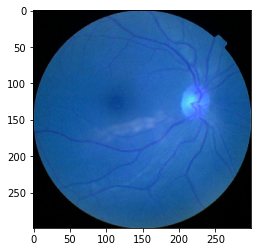

In [14]:
plt.imshow(X_val[76])

## Evaluation functions

In [15]:
# Accuracy and Loss curves
def plot_acc_loss(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

In [16]:
# display confusion matrix heatmap
def confusion_heatmap(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(7,4), dpi=100)
    ax.set(title='Confusion Matrix for the InceptionV3 model')
    disp.plot(ax = ax)
    plt.show()

In [17]:
# calculate weighted_average specificity
def weighted_average_specificity(cm):
    num_classes = 5
    class_counts = []

    for class_label in range(num_classes):
        # Create  binary classification for the current class
        binary_test = [1 if label == class_label else 0 for label in y_test]
         # Count the number of samples for the current class
        class_counts.append(sum(binary_test))
    print(class_counts)   

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity = np.average(specificity, weights = class_counts)
    return specificity

In [18]:
# calculate macro_average specificity
def macro_average_specificity(cm):

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity =np.mean(specificity)
    return specificity

In [19]:
# Calculate the micro-average AUC
def micro_average_auc(y_pred):
    
    micro_avg_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    return micro_avg_auc



In [20]:
# roc curve
def roc_plot(y_pred):

# Binarize actual test labels 
    y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))

    # Compute the ROC curve and AUC for the micro-average
    fpr, tpr, _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
   
    # Plot the micro-average ROC curve
    plt.figure(figsize=(6, 4))
    
    plt.plot(fpr, tpr, color='deeppink', linestyle='-', lw=1)         

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curve')
    plt.show()


## Model Development and Training

In [21]:
# function to build model
def build_model(pre_trained_network):
    base_model = pre_trained_network(weights = 'imagenet', include_top = False, input_shape = (dims,dims,colour_channel))
    
    for layers in base_model.layers:
        layers.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation = 'softmax'))
    print(model.summary())
    
    #compile model
    #specify optimizer, loss and earlytopping
    adam = tf.keras.optimizers.Adam(learning_rate = lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = adam, loss = loss, metrics = METRICS)
    
    return model

In [22]:
colour_channel =3
epochs = 50
lr = 0.001
METRICS=['accuracy']
batch_size = 32
patience = 10
num_classes = 5
dropout = 0.5
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience)

### Build and train model 1 - Inception V3

In [23]:
InceptionV3_model = build_model(InceptionV3)

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None


In [24]:
InceptionV3_model_history = InceptionV3_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val), shuffle =True, callbacks = [callback])
                                            

Epoch 1/50
74/74 [==============================] - 71s 928ms/step - loss: 1.1390 - accuracy: 0.5851 - val_loss: 0.8451 - val_accuracy: 0.6945
Epoch 2/50
74/74 [==============================] - 77s 1s/step - loss: 0.8434 - accuracy: 0.6987 - val_loss: 0.7384 - val_accuracy: 0.7270
Epoch 3/50
74/74 [==============================] - 80s 1s/step - loss: 0.7589 - accuracy: 0.7247 - val_loss: 0.7142 - val_accuracy: 0.7355
Epoch 4/50
74/74 [==============================] - 77s 1s/step - loss: 0.7110 - accuracy: 0.7401 - val_loss: 0.6770 - val_accuracy: 0.7662
Epoch 5/50
74/74 [==============================] - 76s 1s/step - loss: 0.6781 - accuracy: 0.7461 - val_loss: 0.6639 - val_accuracy: 0.7560
Epoch 6/50
74/74 [==============================] - 80s 1s/step - loss: 0.6645 - accuracy: 0.7469 - val_loss: 0.6271 - val_accuracy: 0.7491
Epoch 7/50
74/74 [==============================] - 77s 1s/step - loss: 0.6401 - accuracy: 0.7653 - val_loss: 0.6384 - val_accuracy: 0.7457
Epoch 8/50
74/74 

In [37]:
# save model
InceptionV3_model.save('unprocessed_InceptionV3_model1.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


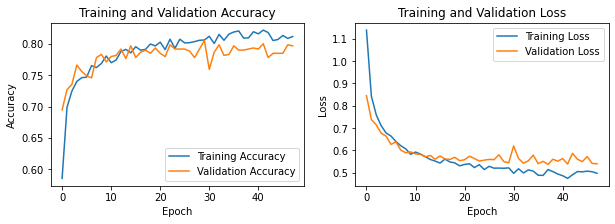

In [26]:
plot_acc_loss(InceptionV3_model_history)

### Evaluate Inception model 

In [27]:
# Predict on test set
inceptionv3_y_pred = InceptionV3_model.predict(X_test)

23/23 [==============================] - 19s 772ms/step


In [28]:
# Classification report
inceptionv3_y_pred_labels = np.argmax(inceptionv3_y_pred, axis=1)
print(classification_report(y_test, inceptionv3_y_pred_labels))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       351
           1       0.61      0.37      0.46        68
           2       0.65      0.85      0.74       213
           3       0.75      0.17      0.27        36
           4       0.49      0.26      0.34        65

    accuracy                           0.78       733
   macro avg       0.68      0.52      0.55       733
weighted avg       0.77      0.78      0.76       733



In [79]:
# Confusion matrix
inceptionv3_conf_matrix = confusion_matrix(y_test, inceptionv3_y_pred_labels)

print(inceptionv3_conf_matrix)

[[342   7   2   0   0]
 [ 12  25  28   0   3]
 [ 12   7 182   1  11]
 [  0   0  26   6   4]
 [  1   2  44   1  17]]


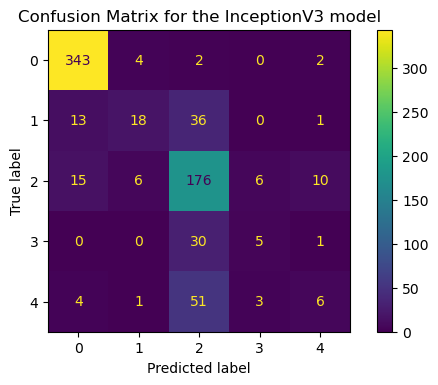

In [42]:
# confusion matrix
confusion_heatmap(inceptionv3_conf_matrix)

In [31]:
# weighted average specificity
inception_wa_specificity = weighted_average_specificity(inceptionv3_conf_matrix)
print(inception_wa_specificity)

[351, 68, 213, 36, 65]
0.908016876209959


In [32]:
inception_ma_specificity = macro_average_specificity(inceptionv3_conf_matrix)
print(inception_ma_specificity)

0.9376743165789632


In [33]:
micro_avg_auc = micro_average_auc(inceptionv3_y_pred)
print("Micro-Average AUC:", micro_avg_auc)


Micro-Average AUC: 0.9015322313998935


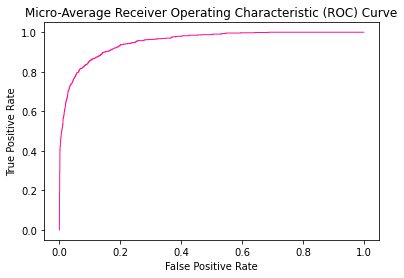

In [34]:
roc_plot(inceptionv3_y_pred)

## Build and train model 2 - ResNet152

In [49]:
# build and compile model
resnet152_model = build_model(ResNet152)

234698864/234698864 [==============================] - 8s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 10, 10, 2048)      58370944  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 58381189 (222.71 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________
None


In [50]:
# fit resnet model
resnet152_model_history = resnet152_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val), shuffle = True, callbacks = [callback])


Epoch 1/50
74/74 [==============================] - 354s 5s/step - loss: 1.5895 - accuracy: 0.4200 - val_loss: 1.2398 - val_accuracy: 0.4710
Epoch 2/50
74/74 [==============================] - 388s 5s/step - loss: 1.3807 - accuracy: 0.4789 - val_loss: 1.2003 - val_accuracy: 0.5358
Epoch 3/50
74/74 [==============================] - 368s 5s/step - loss: 1.3135 - accuracy: 0.5023 - val_loss: 1.1855 - val_accuracy: 0.5375
Epoch 4/50
74/74 [==============================] - 371s 5s/step - loss: 1.2593 - accuracy: 0.5369 - val_loss: 1.1357 - val_accuracy: 0.5597
Epoch 5/50
74/74 [==============================] - 394s 5s/step - loss: 1.2260 - accuracy: 0.5617 - val_loss: 1.1650 - val_accuracy: 0.5154
Epoch 6/50
74/74 [==============================] - 384s 5s/step - loss: 1.1997 - accuracy: 0.5672 - val_loss: 1.1423 - val_accuracy: 0.5546
Epoch 7/50
74/74 [==============================] - 375s 5s/step - loss: 1.1815 - accuracy: 0.5723 - val_loss: 1.1529 - val_accuracy: 0.5870
Epoch 8/50
74

In [51]:
# save model
resnet152_model.save('unprocessed_ResNet152_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


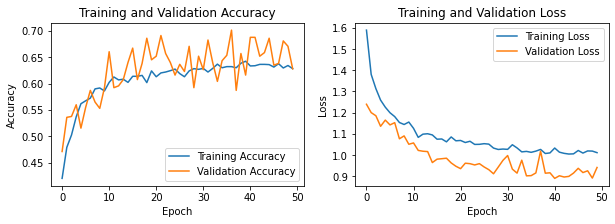

In [52]:
plot_acc_loss(resnet152_model_history)

### Evaluate ResNet152 model

In [53]:
# Predict on test set
resnet152_y_pred = resnet152_model.predict(X_test)

23/23 [==============================] - 88s 4s/step


In [54]:
# Classification report
resnet152_y_pred_labels = np.argmax(resnet152_y_pred, axis=1)
print(classification_report(y_test, resnet152_y_pred_labels))

              precision    recall  f1-score   support

           0       0.67      0.99      0.80       351
           1       0.36      0.47      0.41        68
           2       0.76      0.46      0.58       213
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        65

    accuracy                           0.65       733
   macro avg       0.36      0.38      0.36       733
weighted avg       0.58      0.65      0.59       733



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# Confusion matrix
resnet152_conf_matrix = confusion_matrix(y_test, resnet152_y_pred_labels)

print(resnet152_conf_matrix)

[[347   4   0   0   0]
 [ 29  32   7   0   0]
 [ 79  35  99   0   0]
 [ 24   8   4   0   0]
 [ 36   9  20   0   0]]


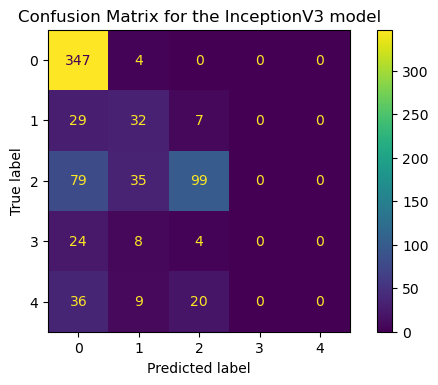

In [56]:
# confusion matrix heatmap
confusion_heatmap(resnet152_conf_matrix)

In [57]:
# weighted average specificity
resnet152_wa_specificity = weighted_average_specificity(resnet152_conf_matrix)
print(resnet152_wa_specificity)

[351, 68, 213, 36, 65]
0.7642689156082572


In [58]:
# macro avg specificity
resnet152_ma_specificity = macro_average_specificity(resnet152_conf_matrix)
print(resnet152_ma_specificity)

0.8832767026305192


In [59]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(resnet152_y_pred)
print("ResNet152 Micro-Average AUC:", micro_avg_auc)


ResNet152 Micro-Average AUC: 0.7967558039136705


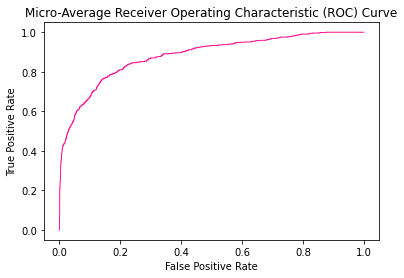

In [60]:
roc_plot(resnet152_y_pred)

## Build and train model 3 - InceptionResNetV2

In [35]:
# build anad compile model
inceptionResnet_model = build_model(InceptionResNetV2)

219055592/219055592 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 7685 (30.02 KB)
Non-trainable params: 54336736 (207.28 MB)
_______

In [36]:
# fit resnet model
inceptionResnet_model_history = inceptionResnet_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val),shuffle = True, callbacks = [callback])


Epoch 1/50
74/74 [==============================] - 222s 3s/step - loss: 1.2240 - accuracy: 0.5651 - val_loss: 0.8757 - val_accuracy: 0.6741
Epoch 2/50
74/74 [==============================] - 207s 3s/step - loss: 0.9327 - accuracy: 0.6650 - val_loss: 0.7664 - val_accuracy: 0.7201
Epoch 3/50
74/74 [==============================] - 218s 3s/step - loss: 0.8384 - accuracy: 0.6906 - val_loss: 0.7325 - val_accuracy: 0.7372
Epoch 4/50
74/74 [==============================] - 217s 3s/step - loss: 0.7873 - accuracy: 0.7162 - val_loss: 0.6978 - val_accuracy: 0.7372
Epoch 5/50
74/74 [==============================] - 213s 3s/step - loss: 0.7533 - accuracy: 0.7230 - val_loss: 0.6714 - val_accuracy: 0.7509
Epoch 6/50
74/74 [==============================] - 211s 3s/step - loss: 0.7419 - accuracy: 0.7247 - val_loss: 0.6544 - val_accuracy: 0.7611
Epoch 7/50
74/74 [==============================] - 209s 3s/step - loss: 0.7080 - accuracy: 0.7315 - val_loss: 0.6353 - val_accuracy: 0.7679
Epoch 8/50
74

In [38]:
# save model
inceptionResnet_model.save('unprocessed_inceptionResnet_model.h5')

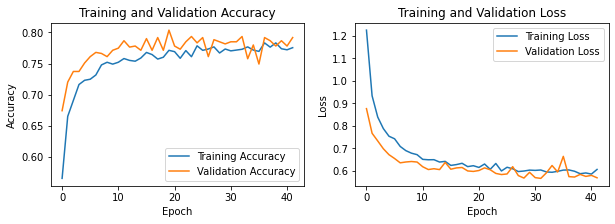

In [39]:
# plot loss and accuracy
plot_acc_loss(inceptionResnet_model_history)

### Evaluate InceptionResNetV2 model

In [40]:
# Predict on test set
inceptionResnet_y_pred = inceptionResnet_model.predict(X_test)

23/23 [==============================] - 58s 2s/step


In [41]:
# Classification report
inceptionResnet_y_pred_labels = np.argmax(inceptionResnet_y_pred, axis=1)
print(classification_report(y_test, inceptionResnet_y_pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       351
           1       0.50      0.59      0.54        68
           2       0.65      0.77      0.71       213
           3       0.67      0.28      0.39        36
           4       0.60      0.14      0.22        65

    accuracy                           0.77       733
   macro avg       0.67      0.55      0.56       733
weighted avg       0.76      0.77      0.75       733



In [42]:
# Confusion matrix
inceptionResnet_conf_matrix = confusion_matrix(y_test, inceptionResnet_y_pred_labels)

print(inceptionResnet_conf_matrix)

[[341   6   4   0   0]
 [ 12  40  15   0   1]
 [ 12  29 165   3   4]
 [  1   1  23  10   1]
 [  3   4  47   2   9]]


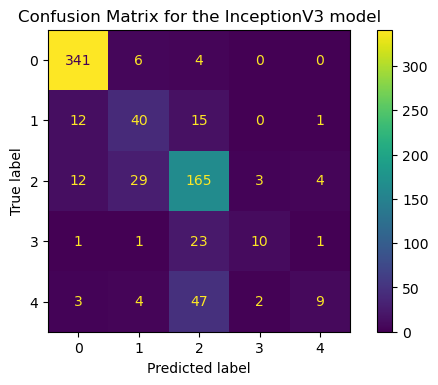

In [43]:
# confusion matrix heatmap
confusion_heatmap(inceptionResnet_conf_matrix)

In [44]:
# weighted average specificity
inceptionResnet_wa_specificity = weighted_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_wa_specificity)

[351, 68, 213, 36, 65]
0.9084368001876838


In [46]:
# macro avg specificity
inceptionResnet_ma_specificity = macro_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_ma_specificity)

0.9358483423022024


In [47]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(inceptionResnet_y_pred)
print("InceptionResNet Micro-Average AUC:", micro_avg_auc)


InceptionResNet Micro-Average AUC: 0.9033260748508365


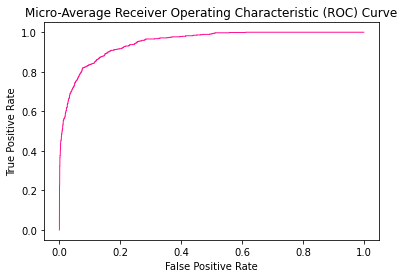

In [48]:
roc_plot(inceptionResnet_y_pred)

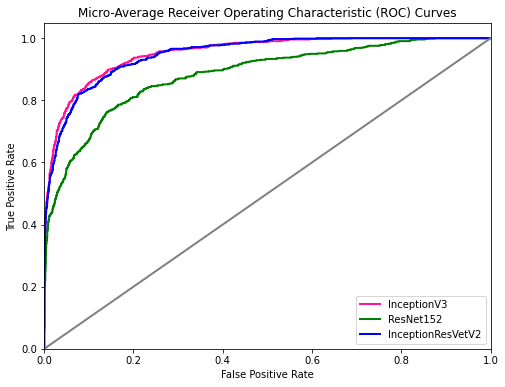

In [61]:
# Binarize actual test labels 
y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))
# Compute the ROC curves and AUC scores for each model
fpr_inception, tpr_inception, _ = roc_curve(y_test_cat.ravel(), inceptionv3_y_pred.ravel())
fpr_resnet, tpr_resnet, _ = roc_curve(y_test_cat.ravel(), resnet152_y_pred.ravel())
fpr_inceptionResnet, tpr_inceptionResnet, _ = roc_curve(y_test_cat.ravel(), inceptionResnet_y_pred.ravel())


# Plot the ROC curves for each model
plt.figure(figsize=(8, 6))

plt.plot(fpr_inception, tpr_inception, color='deeppink', lw=2, label= 'InceptionV3')
plt.plot(fpr_resnet, tpr_resnet, color='green', lw=2, label= 'ResNet152')
plt.plot(fpr_inceptionResnet, tpr_inceptionResnet, color='blue', lw=2, label= 'InceptionResVetV2')

 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## Averaging

In [62]:
model1 = InceptionV3_model
model2 = resnet152_model
model3 = inceptionResnet_model

In [63]:
models = [model1, model2, model3]

In [64]:
preds = [model.predict(X_test) for model in models]

23/23 [==============================] - 45s 2s/step


In [65]:
pred = np.array(preds)

In [66]:
summed = np.sum(preds, axis=0)


In [67]:
mean_preds = np.mean(preds, axis = 0)

In [68]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

In [69]:
print(classification_report(y_test, ensemble_prediction))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       351
           1       0.56      0.50      0.53        68
           2       0.65      0.85      0.74       213
           3       1.00      0.11      0.20        36
           4       0.57      0.12      0.20        65

    accuracy                           0.78       733
   macro avg       0.74      0.51      0.52       733
weighted avg       0.78      0.78      0.74       733



In [70]:
# Confusion matrix
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_prediction)

print(ensemble_conf_matrix)

[[343   6   2   0   0]
 [ 14  34  19   0   1]
 [ 11  17 182   0   3]
 [  1   1  28   4   2]
 [  5   3  49   0   8]]


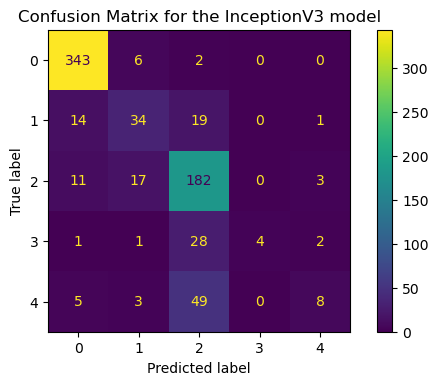

In [71]:
# confusion matrix
confusion_heatmap(ensemble_conf_matrix)

In [72]:
# weighted average specificity
ensemble_wa_specificity = weighted_average_specificity(ensemble_conf_matrix)
print(ensemble_wa_specificity)

[351, 68, 213, 36, 65]
0.9018126391855479


In [73]:
# macro avg specificity
ensemble_ma_specificity = macro_average_specificity(ensemble_conf_matrix)
print(inceptionResnet_ma_specificity)

0.9358483423022024


In [74]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(mean_preds)
print("Ensembled model Micro-Average AUC:", micro_avg_auc)


Ensembled model Micro-Average AUC: 0.9110541965474489


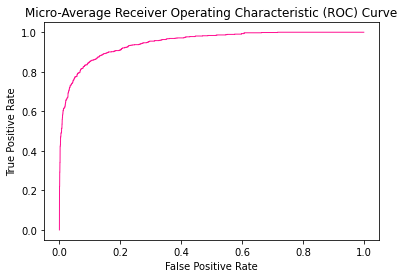

In [75]:
roc_plot(mean_preds)

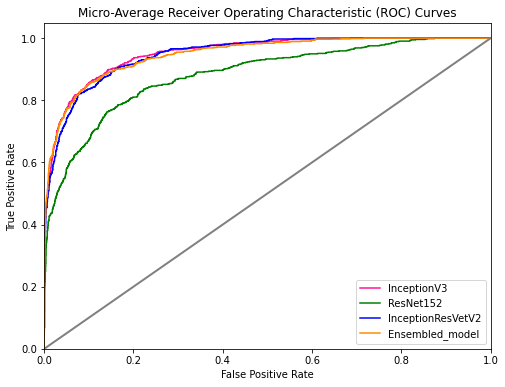

In [76]:
# Binarize actual test labels 
y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))
# Compute the ROC curves and AUC scores for each model
fpr_inception, tpr_inception, _ = roc_curve(y_test_cat.ravel(), inceptionv3_y_pred.ravel())
fpr_resnet, tpr_resnet, _ = roc_curve(y_test_cat.ravel(), resnet152_y_pred.ravel())
fpr_inceptionResnet, tpr_inceptionResnet, _ = roc_curve(y_test_cat.ravel(), inceptionResnet_y_pred.ravel())
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test_cat.ravel(), mean_preds.ravel())

# Plot the ROC curves for each model
plt.figure(figsize=(8, 6))

plt.plot(fpr_inception, tpr_inception, color='deeppink', lw=1.5, label= 'InceptionV3')
plt.plot(fpr_resnet, tpr_resnet, color='green', lw=1.5, label= 'ResNet152')
plt.plot(fpr_inceptionResnet, tpr_inceptionResnet, color='blue', lw=1.5, label= 'InceptionResVetV2')
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=1.5, label= 'Ensembled_model')
 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [78]:
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for average ensemble =  0.7789904502046384
